In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

In [2]:
import pickle

In [3]:
from typing import List, Dict, Any, Tuple

In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [5]:
import colorcet

In [6]:
import glob
from tqdm import tqdm
import json

In [7]:
from bertopic import BERTopic

In [8]:
# Set up LaTeX fonts
#plt.style.use(['no-latex'])
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.unicode'] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']

In [36]:
# read embedding dict from disk
embedding_file = "../data/doc2embedding_only_topics.pkl"

with open(embedding_file, "rb") as file:
    doc2embedding: Dict[str, Dict] = pickle.load(file)

In [37]:
# to get categories, read JSON files
json_files: List = [
    json_file_id.split('/')[-1][:-5]
    for json_file_id in glob.glob('../data/json_files/*.json')
]


doc2json: Dict[str, Dict] = {}

for doc in tqdm(json_files):
    # open the file in read mode
    file_path = "../data/json_files/" + doc + ".json"
    with open(file_path, "r", encoding='utf-8',) as file:
        # Load the JSON data
        doc2json[doc] = json.load(file)

  0%|          | 0/17486 [00:00<?, ?it/s]

100%|██████████| 17486/17486 [00:00<00:00, 78878.47it/s]


In [38]:
document_indexes: List = [
    doc2json[doc]['article_id']
    for doc in doc2json

]
embeddings: np.array = np.array(
    [
        doc2embedding[doc] for doc in doc2json
    ]
)

In [39]:
tsne = TSNE(n_components=2, perplexity=100, random_state=42)

tsne_embeddings = tsne.fit_transform(embeddings)

In [40]:
summaries: List[str] = [
    doc2json[doc]["tldr"]
    for doc in doc2json
]

In [41]:
topic_sentences: List[str] = [
    ' '.join(doc2json[doc]["topics"])
    for doc in doc2json
]

In [42]:
topic_model = BERTopic(
    verbose=True,
    min_topic_size=50,
    #nr_topics="auto",
)

topics, probs = topic_model.fit_transform(
    topic_sentences, 
    embeddings,
)

# Reduce outliers
topics = topic_model.reduce_outliers(topic_sentences, topics)
topic_model.update_topics(topic_sentences, topics=topics)

topic_set = set(topics)

color_set = sns.color_palette(
    colorcet.glasbey,
    n_colors=len(topic_set)
)

topic2color = {
    topic: color
    for topic, color in zip(topic_set, color_set)
}

topic2color[-1] = (0.6, 0.6, 0.6)

topic_names = topic_model.get_topic_info()['Name'].values

topic2name = {
    int(t_name[:t_name.find('_')]): t_name
    for t_name in topic_names
}

2024-05-23 15:03:51,200 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-23 15:04:02,603 - BERTopic - Dimensionality - Completed ✓
2024-05-23 15:04:02,604 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-23 15:04:03,739 - BERTopic - Cluster - Completed ✓
2024-05-23 15:04:03,745 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-05-23 15:04:04,047 - BERTopic - Representation - Completed ✓
100%|██████████| 4/4 [00:00<00:00, 39.14it/s]
2024-05-23 15:04:04,352 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [43]:
topic_model.get_topic_info()

Topic  Count                                          Name  \
0       0   2149           0_chemistry_chemical_heat_reactions   
1       1    837   1_geometry_mathematical_equations_functions   
2       2    755            2_fluid_dynamics_engineering_sound   
3       3    682             3_muscle_nerve_brain_neuroscience   
4       4    634              4_plant_botany_physiology_growth   
..    ...    ...                                           ...   
59     59     71            59_fungal_fungi_pathology_mycology   
60     60     75  60_parallax_celestial_mechanics_astronomical   
61     61     70      61_satellites_jupiters_saturns_satellite   
62     62    101       62_lenses_optical_microscopy_microscope   
63     63     79                  63_corals_coral_marine_algae   

                                       Representation  \
0   [chemistry, chemical, heat, reactions, compoun...   
1   [geometry, mathematical, equations, functions,...   
2   [fluid, dynamics, engineering, sound, mechanic...   
3   [muscle, nerve, brain, neuroscience, neuroanat...   
4   [plant, botany, physiology, growth, tree, plan...   
..                                                ...   
59  [fungal, fungi, pathology, mycology, plant, di...   
60  [parallax, celestial, mechanics, astronomical,...   
61  [satellites, jupiters, saturns, satellite, pla...   
62  [lenses, optical, microscopy, microscope, desi...   
63  [corals, coral, marine, algae, ecology, sponge...   

                                  Representative_Docs  
0   [Organometallic Chemistry Inorganic Chemistry ...  
1   [Differential Equations Mathematical Analysis ...  
2   [Wave Propagation Acoustics Fluid Dynamics Ela...  
3   [Neuroanatomy Muscle Physiology Nerve Fibers M...  
4   [Botany Plant Classification Plant Anatomy Pla...  
..                                                ...  
59  [Fungal taxonomy Ascomycetes Fungal ecology Fu...  
60  [Astronomy Parallax Celestial Mechanics Astron...  
61  [Astronomy Celestial Mechanics Satellite Orbit...  
62  [Microscopy Optical Instruments Optical Design...  
63  [Coral-Line Microscopy Marine Biology Botany R...  

[64 rows x 5 columns]

In [44]:
hierarchical_topics = topic_model.hierarchical_topics(topic_sentences)

100%|██████████| 63/63 [00:00<00:00, 227.37it/s]


In [45]:
article_titles = [
    doc2json[doc]["article_id"] + ': ' + doc2json[doc]["revised_title"] + '. Keyterms: ' + ', '.join(doc2json[doc]["topics"])
    for doc in document_indexes
]
topic_model.visualize_documents(article_titles, reduced_embeddings=tsne_embeddings)


In [46]:
#topic_model.visualize_heatmap(n_clusters=29)

In [27]:
print(topic_model.get_topic_tree(hierarchical_topics))

.
├─astronomy_solar_celestial_astronomical_eclipse
│    ├─solar_eclipse_astronomy_lunar_observations
│    │    ├─■──solar_eclipse_photography_corona_observations ── Topic: 44
│    │    └─■──eclipse_lunar_astronomy_solar_telescopes ── Topic: 36
│    └─astronomy_celestial_astronomical_mechanics_observational
│         ├─celestial_astronomy_mechanics_astronomical_observational
│         │    ├─celestial_astronomy_astronomical_mechanics_comets
│         │    │    ├─■──comets_astronomy_celestial_mechanics_planetary ── Topic: 33
│         │    │    └─■──astronomical_celestial_astronomy_mechanics_star ── Topic: 22
│         │    └─■──satellite_astronomy_eclipses_celestial_satellites ── Topic: 45
│         └─■──transit_venus_astronomy_observational_planetary ── Topic: 41
└─anatomy_magnetic_of_chemical_chemistry
     ├─magnetic_chemical_chemistry_of_analysis
     │    ├─chemical_chemistry_theory_spectroscopy_optical
     │    │    ├─chemical_chemistry_electrical_reactions_spectroscopy
     │   

In [62]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [47]:
topic_model.visualize_barchart(top_n_topics=79, n_words=10)

In [48]:
#topic2label

In [49]:
topic2label = {
    int(t_lable.split()[0]): ', '.join(t_lable.split()[0:])
    for t_lable in topic_model.generate_topic_labels(
        nr_words=20, 
        separator=" "
    )
}

topic2label

{0: '0, chemistry, chemical, heat, reactions, compounds, gas, thermal, organic, spectroscopy, acid',
 1: '1, geometry, mathematical, equations, functions, algebraic, differential, calculus, algebra, series, theory',
 2: '2, fluid, dynamics, engineering, sound, mechanics, hydrodynamics, acoustics, mechanical, elasticity, surface',
 3: '3, muscle, nerve, brain, neuroscience, neuroanatomy, nervous, neural, cerebral, neurophysiology, nerves',
 4: '4, plant, botany, physiology, growth, tree, plants, agriculture, seed, classification, sap',
 5: '5, meteorology, atmospheric, weather, climate, barometer, pressure, temperature, wind, thermometer, science',
 6: '6, magnetic, magnetism, declination, terrestrial, compass, observations, variation, field, geophysics, variations',
 7: '7, electrical, electricity, electromagnetic, electrostatics, electromagnetism, induction, conductivity, experiments, electric, dielectric',
 8: '8, surgery, bone, medical, liver, treatment, digestive, case, digestion, 

In [50]:
def get_category_centroids(
        embeddings_2D: np.array, # 2D tsne embeddings
        category_list: List[str]           # list of categories
    ) -> Dict[str, np.array]:    # return dict of category centroids

    cateogry_embeddings = defaultdict(list)

    for cat, tsne_emb in zip(category_list, embeddings_2D):
        cateogry_embeddings[cat].append(tsne_emb)

    category_centroids = {}

    for cat, embeddings in cateogry_embeddings.items():
        centroid = np.median(embeddings, axis=0)
        category_centroids[cat] = centroid

    return category_centroids

In [51]:
def plot_embedding_2D(
        embeddings_2D: np.array, # 2D tsne embeddings
        category_list: List[str],          # list of categories 
        with_captions: bool = True         # show category captions  
    ) -> None:                             # show plot, return None  


    colors: Dict[str, str] = [
        topic2color[cat] for cat in category_list
    ]
    
    # Create a scatter plot to visualize the t-SNE embeddings
    plt.figure(figsize=(12, 12))

    scatter = plt.scatter(
        embeddings_2D[:, 0], 
        embeddings_2D[:, 1], 
        alpha=0.25, 
        c=colors,
        marker='o',
        s=18
    )

    category_centroids = get_category_centroids(
        embeddings_2D, 
        category_list
    )


    handles = [
        plt.Line2D(
            [],
            [],
            marker='o',
            color=topic2color[cat], 
            linestyle='', 
            markersize=8,
            label=topic2label[cat]
        ) for cat in sorted(list(category_centroids.keys())) 
        if cat != 'Other'
    ]

    if with_captions:

        for cat, centroid in category_centroids.items():

            if cat == "Other":
                continue

            #rand_int = random.randint(-5, 5)

            plt.text(
                centroid[0], #- 15, 
                centroid[1], #- rand_int, 
                cat, #r"${{{}}}$".format(category2text[cat]), 
                fontdict=dict(fontsize=24, fontweight='normal', color='black'), 
                bbox=dict(
                    facecolor=topic2color[cat], 
                    alpha=0.5, 
                    linewidth=0, 
                    boxstyle='round,pad=0.1'
                    )
                )

    plt.legend(
        handles=handles, 
        title="", 
        fontsize=18, 
        framealpha=0,
        #loc='lower center',
        loc='upper left', 
        #bbox_to_anchor=(0.5, -0.25), 
        bbox_to_anchor=(1, 1), 
        #ncols=3,
        ncols=1,
    )


    plt.title('t-SNE projections', fontsize=16)
    #plt.xlabel('t-SNE Dimension 1')
    #plt.ylabel('t-SNE Dimension 2')
    #plt.ylim(-100, 100)
    #plt.xlim(-110, 110)

    plt.show()    

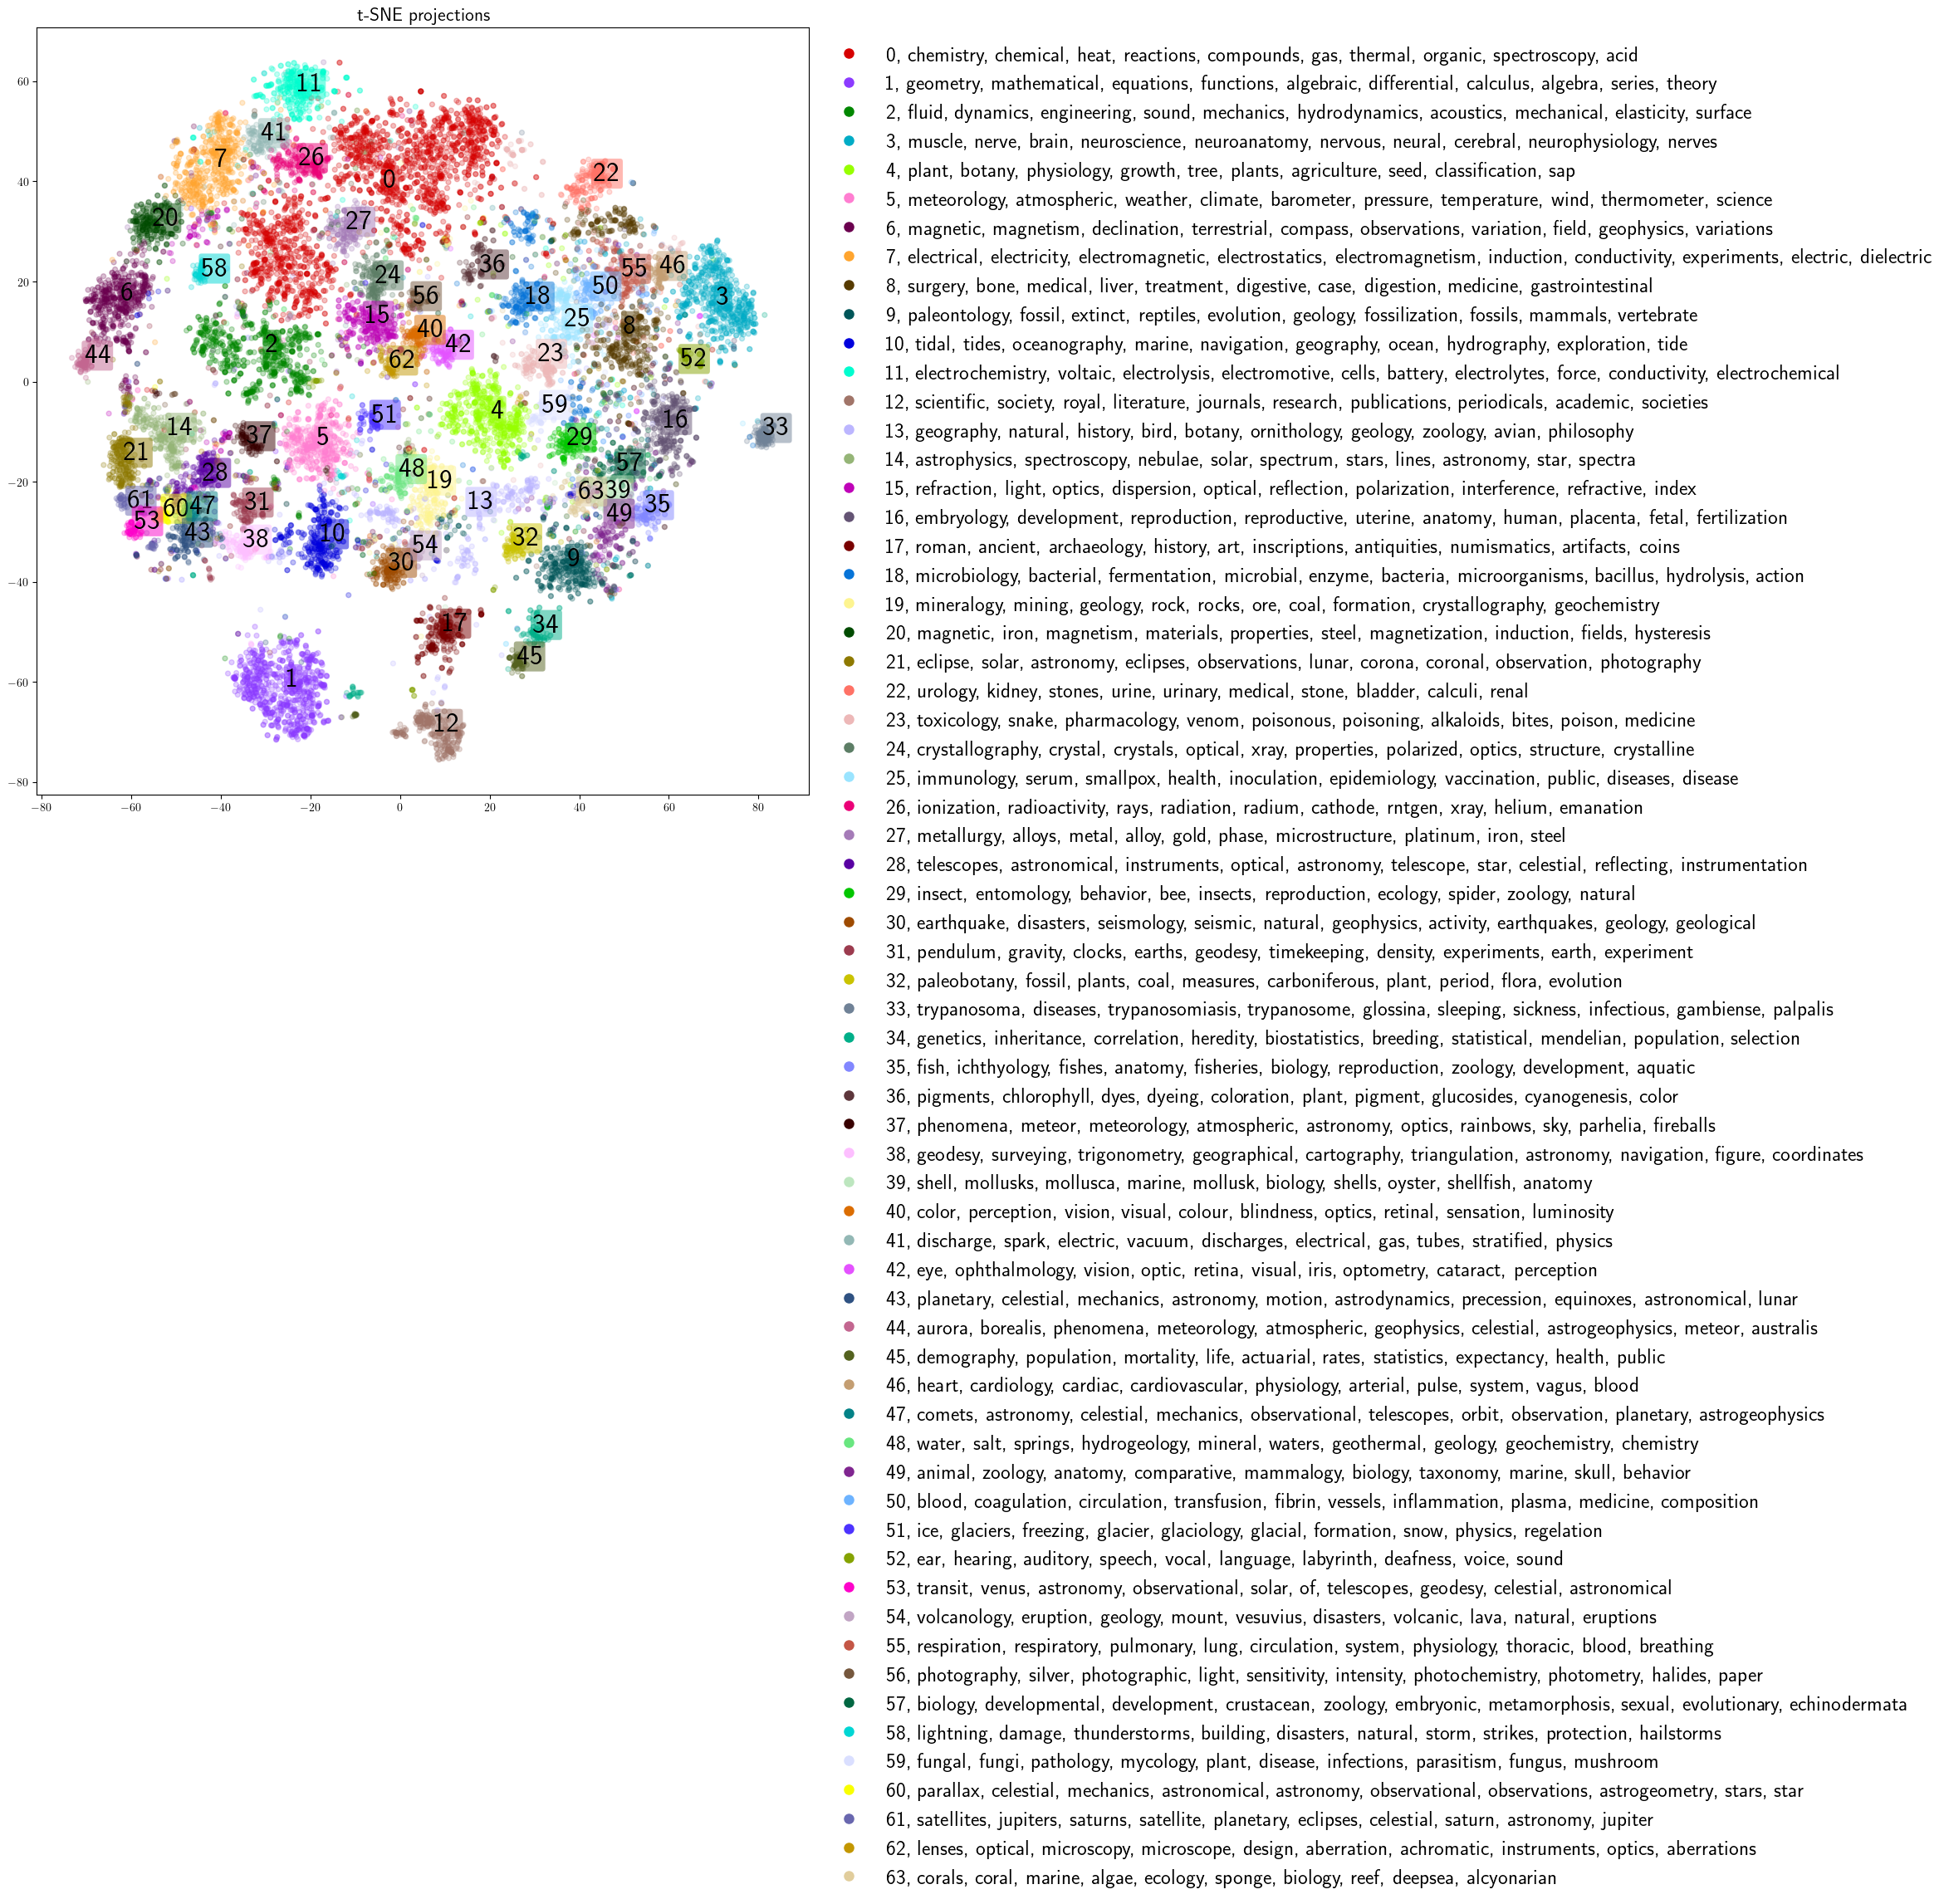

In [52]:
plot_embedding_2D(tsne_embeddings, topics, with_captions=True)

In [53]:

# read the metadat file into a pandas dataframe
metadata_file = '../data/Royal_Society_Corpus_open_v6.0_meta.tsv'

metadata_df = pd.read_csv(metadata_file, delimiter='\t')

metadata_df.head()

id       issn  \
0  rspa_1905_0001  0950-1207   
1  rspa_1905_0002  0950-1207   
2  rspa_1905_0003  0950-1207   
3  rspa_1905_0004  0950-1207   
4  rspa_1905_0005  0950-1207   

                                               title fpage lpage  year  \
0  Address delivered by the President, Sir Willia...     1    29  1905   
1  The boring of the Simplon Tunnel, and the dist...    29    33  1905   
2  On a method of finding the conductivity for heat.    34    48  1905   
3  Theory of the reflection of light near the pol...    49    65  1905   
4  On the relation between variations of atmosphe...    66    86  1905   

   volume                                            journal  \
0      76  Proceedings of the Royal Society of London. Se...   
1      76  Proceedings of the Royal Society of London. Se...   
2      76  Proceedings of the Royal Society of London. Se...   
3      76  Proceedings of the Royal Society of London. Se...   
4      76  Proceedings of the Royal Society of London. Se...   

                                              author     type  ... tokens  \
0      Sir William Huggins K. C. B., O. M., F. R. S.   speech  ...  14279   
1  Francis Fox, M. Inst. C. E. |C. V. Boys, F. R. S.  article  ...   1816   
2                       Professor C. Niven, F. R. S.  article  ...   3624   
3  Richard C. Maclaurin, M. A., LL. D.|Professor ...  article  ...   2722   
4  Captain H. G. Lyons|Sir W. E. Garstin, G. C. M...  article  ...  10079   

                                   visualizationLink                     doi  \
0  http://corpora.clarin-d.uni-saarland.de/surpri...  10.1098/rspa.1905.0001   
1  http://corpora.clarin-d.uni-saarland.de/surpri...  10.1098/rspa.1905.0002   
2  http://corpora.clarin-d.uni-saarland.de/surpri...  10.1098/rspa.1905.0003   
3  http://corpora.clarin-d.uni-saarland.de/surpri...  10.1098/rspa.1905.0004   
4  http://corpora.clarin-d.uni-saarland.de/surpri...  10.1098/rspa.1905.0005   

  jstorLink  hasAbstract  isAbstractOf  primaryTopic  primaryTopicPercentage  \
0       NaN          NaN           NaN     Biography               87.018807   
1       NaN          NaN           NaN     Geography               34.843817   
2       NaN          NaN           NaN   Electricity               22.229782   
3       NaN          NaN           NaN        Tables               38.543461   
4       NaN          NaN           NaN   Meteorology               51.203697   

   secondaryTopic  secondaryTopicPercentage  
0      Immunology                  3.397728  
1  Thermodynamics                 26.224835  
2        Formulae                 19.054271  
3  Fluid Dynamics                 28.361855  
4       Geography                 22.031809  

[5 rows x 29 columns]

In [59]:
# add year, decade, and period to the dictionaries in doc2json

for doc in tqdm(doc2json):
    df_row = metadata_df.loc[metadata_df['id'] == doc]
    year = df_row['year'].values[0]
    decade = df_row['decade'].values[0]
    period = df_row['period'].values[0]

    doc2json[doc]['year'] = year
    doc2json[doc]['decade'] = decade
    doc2json[doc]['period'] = period

  0%|          | 0/17486 [00:00<?, ?it/s]

100%|██████████| 17486/17486 [00:13<00:00, 1287.74it/s]


In [67]:
decades = [
    doc2json[doc]['decade'] for doc in document_indexes
]

In [68]:

topics_over_time = topic_model.topics_over_time(topic_sentences, decades)

topic_model.visualize_topics_over_time(topics_over_time, topics=[15, 40, 42, 62])

0it [00:00, ?it/s]

27it [00:01, 19.97it/s]
